In [ ]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

In [ ]:
image_folder = '/content/puppies'
img_height, img_width = 64, 64

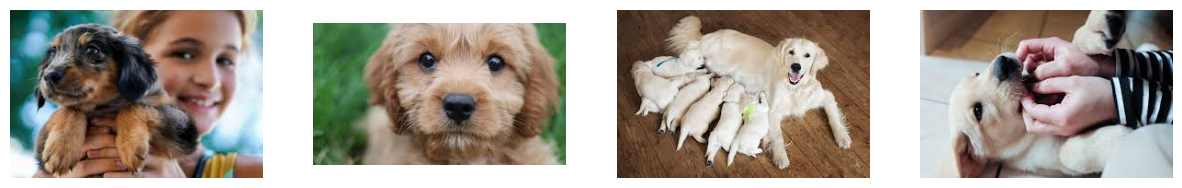

In [ ]:
image_files = os.listdir(image_folder)
random.shuffle(image_files)

n = 4
plt.figure(figsize=(15, 5))

for i in range(n):
    img_path = os.path.join(image_folder, image_files[i])
    img = Image.open(img_path).convert('RGB')
    ax = plt.subplot(1, n, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path): # Check if it is a file
            img = Image.open(img_path).convert('RGB')
            img = img.resize((img_height, img_width))
            img_array = img_to_array(img)
            images.append(img_array)
    return np.array(images)

In [ ]:
# Load and normalize images
x_train = load_images_from_folder(image_folder)
x_train = x_train.astype('float32') / 255.0
print(f"Dataset shape: {x_train.shape}")

Dataset shape: (297, 64, 64, 3)


In [ ]:
# Add random noise to the images
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

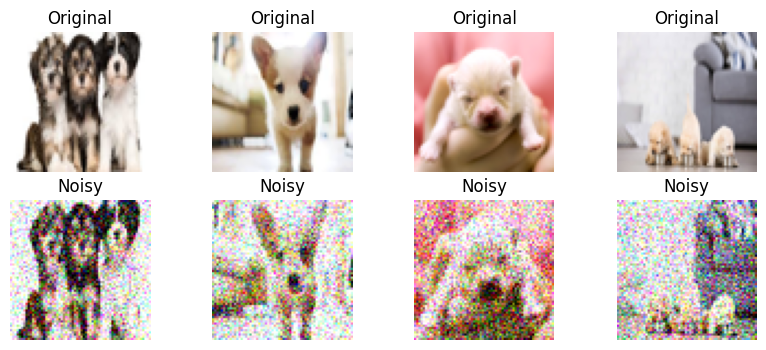

In [ ]:
# Display original and noisy images
n = 4
plt.figure(figsize=(10, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(array_to_img(x_train[i]))
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(array_to_img(x_train_noisy[i]))
    plt.title("Noisy")
    plt.axis('off')
plt.show()

In [ ]:
from keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Define the autoencoder architecture
input_img = Input(shape=(img_height, img_width, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Build the autoencoder
autoencoder = Model(input_img, decoded)

optimizer = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss='mse')
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 16, 16, 32)        9248

In [ ]:
history = autoencoder.fit(x_train, x_train_noisy,
                          epochs=10,
                          batch_size=128,
                          validation_split=0.1,
                          shuffle=True)

Epoch 1/10
3/3 [==============================] - 1s 199ms/step - loss: 0.0896 - val_loss: 0.0894
Epoch 2/10
3/3 [==============================] - 1s 148ms/step - loss: 0.0825 - val_loss: 0.0827
Epoch 3/10
3/3 [==============================] - 0s 136ms/step - loss: 0.0789 - val_loss: 0.0791
Epoch 4/10
3/3 [==============================] - 0s 137ms/step - loss: 0.0747 - val_loss: 0.0728
Epoch 5/10
3/3 [==============================] - 0s 130ms/step - loss: 0.0690 - val_loss: 0.0658
Epoch 6/10
3/3 [==============================] - 0s 144ms/step - loss: 0.0634 - val_loss: 0.0597
Epoch 7/10
3/3 [==============================] - 0s 132ms/step - loss: 0.0587 - val_loss: 0.0560
Epoch 8/10
3/3 [==============================] - 0s 136ms/step - loss: 0.0558 - val_loss: 0.0531
Epoch 9/10
3/3 [==============================] - 0s 131ms/step - loss: 0.0530 - val_loss: 0.0543
Epoch 10/10
3/3 [==============================] - 0s 133ms/step - loss: 0.0532 - val_loss: 0.0519


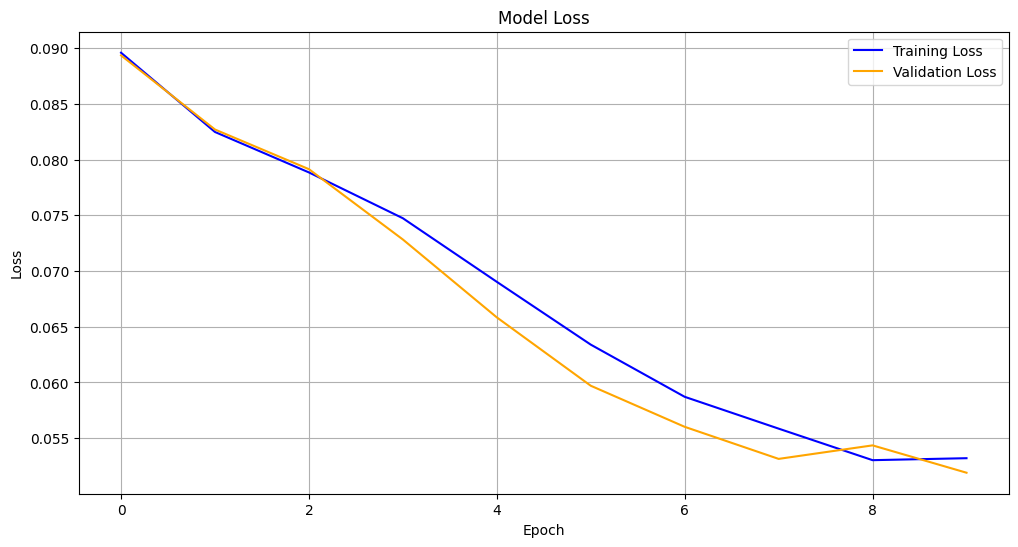

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()

10/10 [==============================] - 0s 11ms/step


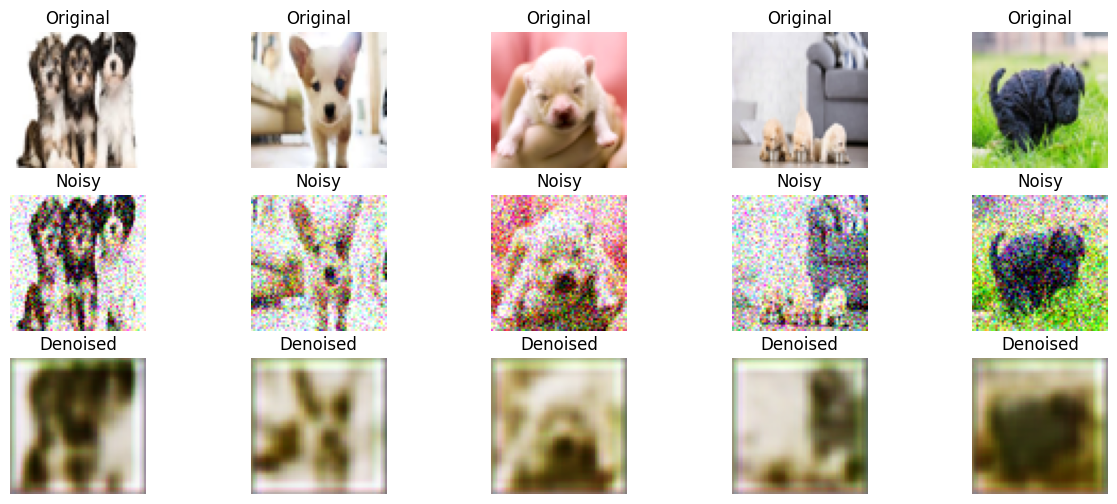

In [ ]:

# Denoise the images using the trained autoencoder
x_train_denoised = autoencoder.predict(x_train_noisy)


n = 5
plt.figure(figsize=(15, 6))
for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(array_to_img(x_train[i]))
    plt.title("Original")
    plt.axis('off')

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(array_to_img(x_train_noisy[i]))
    plt.title("Noisy")
    plt.axis('off')

    # Denoised images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(array_to_img(x_train_denoised[i]))
    plt.title("Denoised")
    plt.axis('off')
plt.show()
